In [36]:
# UNCOMMENT first with internet option turned on
# Use GPU env

# !pip download tabpfn --no-deps -d pip-packages

# from tabpfn import TabPFNClassifier
# TabPFNClassifier(N_ensemble_configurations = 64, device = 'cuda:0')

# !mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
# !zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below

In [37]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

In [38]:
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE, RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

### Data Pull

In [40]:
# load data
train_df = pd.read_csv('icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv('icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv('icr-identify-age-related-conditions/greeks.csv')

# join greeks and add Epsilon
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['EJ', 'Alpha', 'Beta', 'Gamma', 'Delta'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)

# dropping rows with missing values in Epsilon as it helps with class imbalance
# if future data does have this column, it will be important to know if it is missing
train_df = train_df[train_df['Epsilon'].isna() == False].copy()
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])

# change epsilon to months since 1-1-2019 when data started to pick up
train_df['Months Since 1-1-2019'] = (train_df['Epsilon'] - pd.to_datetime('2019-01-01')).dt.days // 30
train_df = train_df.drop('Epsilon', axis = 1)
train_df.reset_index(drop = True, inplace = True)

In [41]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

# Preprocess Data

In [42]:
# set random seed
random_seed = 101010
np.random.seed(random_seed)

# pre-process data
y = train_df['Class']
x = train_df.drop(['Id', 'Class'], axis = 1, inplace = False)

# create x and y train
X_train = x.copy()
y_train = y.copy()

# scale and impute data
X_train_columns = X_train.columns
X_train_index = X_train.index
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
knn_imputer = KNNImputer()
X_train = knn_imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_train_columns, index = X_train_index)

# Engineer Features

### Model Prediction Features
KNN, Logistic Regression, SVM, Gradient Boosting, and TabPFN

In [43]:
def fit_model(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    model.fit(X, y)
    model_predictions = model.predict_proba(test)[:, 1]
    predictions_df = pd.DataFrame({model_name: model_predictions}, index = X_test.index)
    
    return predictions_df

In [44]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train[train_index], y_train[test_index]
    
    model_features = [
        'DU', 'CR', 'AB', 'DA', 'DH', 'BC', 'FR', 'EP', 'DI', 'FL', 'EU', 'EH', 'Months Since 1-1-2019'
    ]
    
    # KNN
    knn_features = model_features[0:3]
    knn_features.append(model_features[-1])
    knn = KNeighborsClassifier(n_neighbors = 5)
    knn_predictions = fit_model('KNN 5', knn, fold, fold_y, oof, knn_features)
    
    # Logistic Regression
    log_reg = LogisticRegression(C = 0.1, max_iter = 1000, random_state = random_seed)
    log_reg_predictions = fit_model('Logistic Regression', knn, fold, fold_y, oof, model_features)
    
    # SVM
    svm = SVC(C = 10, gamma = 0.01, probability = True, random_state = random_seed)
    svm_predictions = fit_model('SVM', svm, fold, fold_y, oof, model_features)
    
    # Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, random_state = random_seed)
    gb_predictions = fit_model('Gradient Boosting', gb, fold, fold_y, oof, model_features)
    
    # TabPFN
    tabpfn = TabPFNClassifier(N_ensemble_configurations = 20, seed = random_seed)
    tabpfn_predictions = fit_model('TabPFN', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([knn_predictions, log_reg_predictions, svm_predictions, gb_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [45]:
pre_fit_models = {
    'KNN 5': knn.fit(X_train[knn_features], y_train),
    'Logistic Regression': log_reg.fit(X_train[model_features], y_train),
    'SVM': svm.fit(X_train[model_features], y_train),
    'Gradient Boosting': gb.fit(X_train[model_features], y_train),
    'TabPFN': tabpfn.fit(X_train[model_features], y_train)
}

X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)

In [46]:
# cols_for_interdependance = ['DU', 'CR', 'AB', 'DA', 'DH', 'Months Since 1-1-2019']

# for col_a, col_b in itertools.combinations(cols_for_interdependance, 2):
#     X_train[col_a + ' * ' + col_b] = X_train[col_a] * X_train[col_b]
#     X_test[col_a + ' * ' + col_b] = X_test[col_a] * X_test[col_b]

In [47]:
print('Shape of X:', X_train.shape)
print('Shape of y:', y_train.shape)

Shape of X: (473, 61)
Shape of y: (473,)


In [48]:
# print('Shape of X:', X_test.shape)
# print('Shape of y:', y_test.shape)

# Modeling

In [49]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = 1 - proba_1
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

### XGBoost

In [50]:
xgb = XGBClassifier(random_state = random_seed)

parameters = {
    'booster': ['gbtree'],
    'n_jobs': [-1],
    'learning_rate': [0.02],
    'n_estimators': [300],
    'base_score': [0.85],
    'gamma': [0.3],
    'max_depth': [6],
    'min_child_weight': [2],
    'max_delta_step': [1],
    'subsample': [0.7]
}

grid_obj = GridSearchCV(xgb, parameters, scoring = balanced_log_loss_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)
xgb = grid_obj.best_estimator_
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.85, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=101010, reg_alpha=0, reg_lambda=1, ...)

In [51]:
# view results of grid search
xgb_results = pd.DataFrame(grid_obj.cv_results_)
xgb_results.sort_values('rank_test_score')
# print results of roc auc score
print('Balanced Log Loss:', np.round(xgb_results['mean_test_score'].max() * -1, 4))

Balanced Log Loss: 0.2372


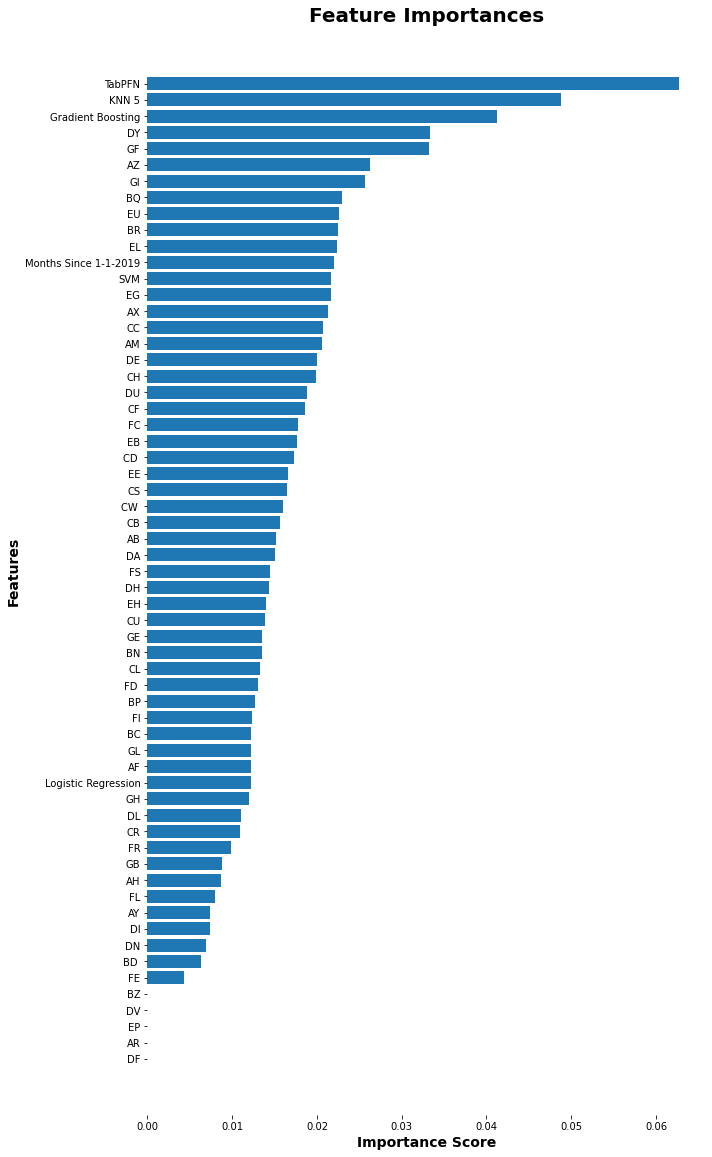

In [52]:
# plot feature importances
importances = pd.Series(xgb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

### Test Sampling Strategies

In [53]:
def model_cross_validation(X, y, models, model_names, n_splits = 5):
    skf = StratifiedKFold(n_splits = n_splits, random_state = random_seed, shuffle = True)
    
    # create dataframe to hold results
    results_df = pd.DataFrame(columns = ['Model', 'Fold', 'Accuracy', 'ROC AUC', 'Log Loss'])
    
    for sampling_strategy in ['None', 'SMOTE', 'RandomOverSampler']:
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            if sampling_strategy == 'SMOTE':
                X_train, y_train = SMOTE(random_state = random_seed).fit_resample(X_train, y_train)
            elif sampling_strategy == 'RandomOverSampler':
                X_train, y_train = RandomOverSampler(random_state = random_seed).fit_resample(X_train, y_train)
            else:
                pass
        
            for model, model_name in zip(models, model_names):
                if sampling_strategy == 'None':
                    model_name = model_name
                else:
                    model_name = model_name + ' with ' + sampling_strategy
                
                print(model_name, 'Fold', i + 1)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]
                
                fold_accuracy = accuracy_score(y_test, y_pred)
                fold_roc_auc = roc_auc_score(y_test, y_proba)
                fold_log_loss = competition_log_loss(y_test, y_proba)
                
                new_result_index = len(results_df)
                new_results_row = pd.DataFrame({
                    'Model': model_name, 
                    'Fold': i + 1, 
                    'Accuracy': fold_accuracy, 
                    'ROC AUC': fold_roc_auc,
                    'Log Loss': fold_log_loss
                }, index = [new_result_index])
                
                results_df = pd.concat([results_df, new_results_row])
        print()
        
    return results_df

In [54]:
models = [xgb]
model_names = ['XGBoost']

In [55]:
cv_results = model_cross_validation(X_train, y_train, models, model_names)

XGBoost Fold 1
XGBoost Fold 2
XGBoost Fold 3
XGBoost Fold 4
XGBoost Fold 5

XGBoost with SMOTE Fold 1
XGBoost with SMOTE Fold 2
XGBoost with SMOTE Fold 3
XGBoost with SMOTE Fold 4
XGBoost with SMOTE Fold 5

XGBoost with RandomOverSampler Fold 1
XGBoost with RandomOverSampler Fold 2
XGBoost with RandomOverSampler Fold 3
XGBoost with RandomOverSampler Fold 4
XGBoost with RandomOverSampler Fold 5



In [56]:
# find best sampling strategy for submission
results = cv_results.drop('Fold', axis = 1).groupby('Model').mean()
results['Accuracy Z Score'] = (results['Accuracy'] - results['Accuracy'].mean()) / results['Accuracy'].std()
results['ROC AUC Z Score'] = (results['ROC AUC'] - results['ROC AUC'].mean()) / results['ROC AUC'].std()
results['Log Loss Z Score'] = ((results['Log Loss'] - results['Log Loss'].mean()) / results['Log Loss'].std()) * -1
results['Average Z Score'] = results[['ROC AUC Z Score','Log Loss Z Score']].mean(axis = 1)
results.sort_values('Log Loss Z Score', ascending = False)

,Accuracy,ROC AUC,Log Loss,Accuracy Z Score,ROC AUC Z Score,Log Loss Z Score,Average Z Score
Model,,,,,,,
XGBoost with SMOTE,0.947100,0.964899,0.219224,0.127475,-1.117469,0.954659,-0.081405
XGBoost with RandomOverSampler,0.940784,0.967396,0.235148,-1.057625,0.810623,0.085227,0.447925
XGBoost,0.951377,0.966744,0.255756,0.930150,0.306846,-1.039886,-0.366520


### Submission

In [57]:
def prediction_pipeline(X):
    X = X.select_dtypes(include = [np.number])
    X['Months Since 1-1-2019'] = [X_train['Months Since 1-1-2019'].max() + 1] * len(X)
    
    X_columns = X.columns
    X_index = X.index
    
    X = standard_scaler.transform(X)
    X = knn_imputer.transform(X)
    X = pd.DataFrame(X, columns = X_columns, index = X_index)

    for model in pre_fit_models:
        if model == 'KNN 5':
            X[model] = pre_fit_models[model].predict_proba(X[knn_features])[:, 1]
        else:
            X[model] = pre_fit_models[model].predict_proba(X[model_features])[:, 1]
    
    model_train, model_y = SMOTE(random_state = random_seed).fit_resample(X_train, y_train)
    
    xgb.fit(model_train, model_y)
    xgb_prediction = xgb.predict_proba(X)
    
    X['class_0'] = xgb_prediction[:, 0]
    X['class_1'] = xgb_prediction[:, 1]
        
    return X

In [58]:
X_test = prediction_pipeline(test_df)

In [59]:
predictions = X_test[['class_0', 'class_1']]
submission = pd.concat([test_df[['Id']], predictions], axis = 1)
submission.to_csv('submission.csv', index = False)

In [60]:
submission

,Id,class_0,class_1
0,00eed32682bb,0.327081,0.672919
1,010ebe33f668,0.327081,0.672919
2,02fa521e1838,0.327081,0.672919
3,040e15f562a2,0.327081,0.672919
4,046e85c7cc7f,0.327081,0.672919
